In [ ]:
https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial

In [ ]:
!sudo apt-get install -y xvfb ffmpeg
!pip install gym
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install pyglet
!pip install pyvirtualdisplay
!pip install tf-agents

In [ ]:
sudo apt-get install -y xvfb ffmpeg
pip install -q gym
pip install -q 'imageio==2.4.0'
pip install -q PILLOW
pip install -q pyglet
pip install -q pyvirtualdisplay
pip install -q tf-agents


Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 1s (907 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected pack

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [ ]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


In [ ]:
tf.version.VERSION

'2.4.0'

In [ ]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


In [ ]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)


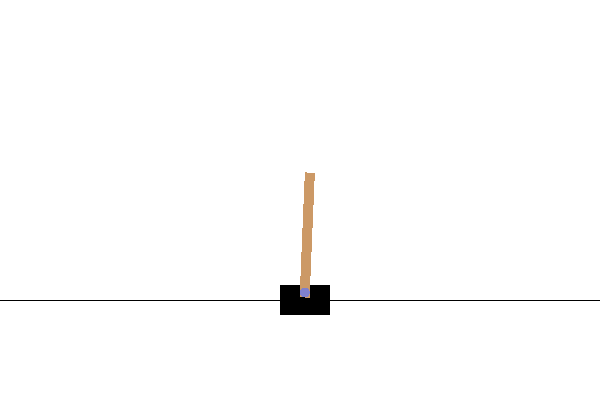

In [ ]:
env.reset()
PIL.Image.fromarray(env.render())


In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)


Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)


Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [ ]:
print('Action Spec:')
print(env.action_spec())


Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)


Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.00768841,  0.00503232,  0.04861919, -0.02026419], dtype=float32))
Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.00758776,  0.19942452,  0.04821391, -0.2972195 ], dtype=float32))


In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)


In [ ]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [ ]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))


In [ ]:
time_step = example_environment.reset()


In [ ]:
random_policy.action(time_step)


PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics


In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)


18.0

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)


In [ ]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [ ]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [ ]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers


In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [ ]:
iterator = iter(dataset)

print(iterator)


In [ ]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 12.0142822265625
step = 400: loss = 8.146712303161621
step = 600: loss = 3.640962839126587
step = 800: loss = 9.64122200012207
step = 1000: loss = 10.413800239562988
step = 1000: Average Return = 25.0
step = 1200: loss = 20.222763061523438
step = 1400: loss = 34.918312072753906
step = 1600: loss = 33.32453918457031
step = 1800: loss = 33.69557189941406
step = 2000: loss = 51.75933074951172
step = 2000: Average Return = 36.900001525878906
step = 2200: loss = 41.017616271972656
step = 2400: loss = 36.963523864746094
step = 2600: loss = 21.112293243408203
step = 2800: loss = 37.80777359008789
step = 3000: loss = 31.88629722595215
step = 3000: Average Return = 65.5999984741211
step = 3200: loss = 39.99583435058594
step = 3400: loss = 36.930816650390625
step = 3600: loss = 79.30089569091797
step = 3800: loss = 57.53923797607422
step = 4000: loss = 28.717811584472656
step = 4000: Average Return = 163.10000610351562
step = 4200: loss = 69.99690246582031
step = 4400: loss = 

(-0.44499959945678746, 250.0)

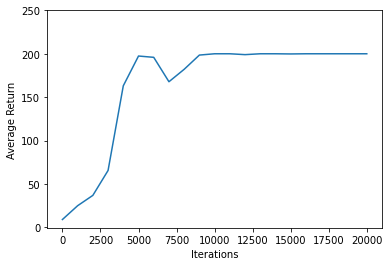

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)


In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)


In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")


In [ ]:
create_policy_eval_video(random_policy, "random-agent")


In [ ]:
pip install -q tf-agents
pip install -q gym


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()


In [ ]:
class PyEnvironment(object):

  def reset(self):
    """Return initial_time_step."""
    self._current_time_step = self._reset()
    return self._current_time_step

  def step(self, action):
    """Apply action and return new time_step."""
    if self._current_time_step is None:
        return self.reset()
    self._current_time_step = self._step(action)
    return self._current_time_step

  def current_time_step(self):
    return self._current_time_step

  def time_step_spec(self):
    """Return time_step_spec."""

  @abc.abstractmethod
  def observation_spec(self):
    """Return observation_spec."""

  @abc.abstractmethod
  def action_spec(self):
    """Return action_spec."""

  @abc.abstractmethod
  def _reset(self):
    """Return initial_time_step."""

  @abc.abstractmethod
  def _step(self, action):
    """Apply action and return new time_step."""


In [ ]:
environment = suite_gym.load('CartPole-v0')
print('action_spec:', environment.action_spec())
print('time_step_spec.observation:', environment.time_step_spec().observation)
print('time_step_spec.step_type:', environment.time_step_spec().step_type)
print('time_step_spec.discount:', environment.time_step_spec().discount)
print('time_step_spec.reward:', environment.time_step_spec().reward)


action_spec: BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)
time_step_spec.observation: BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
time_step_spec.step_type: ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')
time_step_spec.discount: BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0)
time_step_spec.reward: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [ ]:
action = np.array(1, dtype=np.int32)
time_step = environment.reset()
print(time_step)
while not time_step.is_last():
  time_step = environment.step(action)
  print(time_step)


TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.04048501,  0.02938754, -0.03548152, -0.0374779 ], dtype=float32))
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.04107276,  0.22499986, -0.03623108, -0.34114107], dtype=float32))
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.04557276,  0.42061806, -0.0430539 , -0.64502543], dtype=float32))
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.05398512,  0.61631274, -0.05595441, -0.9509493 ], dtype=float32))
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.06631137,  0.8121413 , -0.0749734 , -1.2606745 ], dtype=float32))
TimeStep(s

In [ ]:
class CardGameEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state], dtype=np.int32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    # Make sure episodes don't go on forever.
    if action == 1:
      self._episode_ended = True
    elif action == 0:
      new_card = np.random.randint(1, 11)
      self._state += new_card
    else:
      raise ValueError('`action` should be 0 or 1.')

    if self._episode_ended or self._state >= 21:
      reward = self._state - 21 if self._state <= 21 else -21
      return ts.termination(np.array([self._state], dtype=np.int32), reward)
    else:
      return ts.transition(
          np.array([self._state], dtype=np.int32), reward=0.0, discount=1.0)


In [ ]:
environment = CardGameEnv()
utils.validate_py_environment(environment, episodes=5)


In [ ]:
get_new_card_action = np.array(0, dtype=np.int32)
end_round_action = np.array(1, dtype=np.int32)

environment = CardGameEnv()
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward

for _ in range(3):
  time_step = environment.step(get_new_card_action)
  print(time_step)
  cumulative_reward += time_step.reward

time_step = environment.step(end_round_action)
print(time_step)
cumulative_reward += time_step.reward
print('Final Reward = ', cumulative_reward)


TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0], dtype=int32))
TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([6], dtype=int32))
TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([16], dtype=int32))
TimeStep(step_type=array(2, dtype=int32), reward=array(-21., dtype=float32), discount=array(0., dtype=float32), observation=array([24], dtype=int32))
TimeStep(step_type=array(2, dtype=int32), reward=array(-21., dtype=float32), discount=array(0., dtype=float32), observation=array([24], dtype=int32))
Final Reward =  -42.0


In [ ]:
env = suite_gym.load('Pendulum-v0')
print('Action Spec:', env.action_spec())

discrete_action_env = wrappers.ActionDiscretizeWrapper(env, num_actions=5)
print('Discretized Action Spec:', discrete_action_env.action_spec())


Action Spec: BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=-2.0, maximum=2.0)
Discretized Action Spec: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=4)


In [ ]:
class TFEnvironment(object):

  def time_step_spec(self):
    """Describes the `TimeStep` tensors returned by `step()`."""

  def observation_spec(self):
    """Defines the `TensorSpec` of observations provided by the environment."""

  def action_spec(self):
    """Describes the TensorSpecs of the action expected by `step(action)`."""

  def reset(self):
    """Returns the current `TimeStep` after resetting the Environment."""
    return self._reset()

  def current_time_step(self):
    """Returns the current `TimeStep`."""
    return self._current_time_step()

  def step(self, action):
    """Applies the action and returns the new `TimeStep`."""
    return self._step(action)

  @abc.abstractmethod
  def _reset(self):
    """Returns the current `TimeStep` after resetting the Environment."""

  @abc.abstractmethod
  def _current_time_step(self):
    """Returns the current `TimeStep`."""

  @abc.abstractmethod
  def _step(self, action):
    """Applies the action and returns the new `TimeStep`."""


In [ ]:
env = suite_gym.load('CartPole-v0')
tf_env = tf_py_environment.TFPyEnvironment(env)

print(isinstance(tf_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())


True
TimeStep Specs: TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)))
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))


In [ ]:
env = suite_gym.load('CartPole-v0')

tf_env = tf_py_environment.TFPyEnvironment(env)
# reset() creates the initial time_step after resetting the environment.
time_step = tf_env.reset()
num_steps = 3
transitions = []
reward = 0
for i in range(num_steps):
  action = tf.constant([i % 2])
  # applies the action and returns the new TimeStep.
  next_time_step = tf_env.step(action)
  transitions.append([time_step, action, next_time_step])
  reward += next_time_step.reward
  time_step = next_time_step

np_transitions = tf.nest.map_structure(lambda x: x.numpy(), transitions)
print('\n'.join(map(str, np_transitions)))
print('Total reward:', reward.numpy())


[TimeStep(step_type=array([0], dtype=int32), reward=array([0.], dtype=float32), discount=array([1.], dtype=float32), observation=array([[ 0.04411125, -0.01557221,  0.04244439, -0.03571694]],
      dtype=float32)), array([0], dtype=int32), TimeStep(step_type=array([1], dtype=int32), reward=array([1.], dtype=float32), discount=array([1.], dtype=float32), observation=array([[ 0.0437998 , -0.21127631,  0.04173005,  0.27004972]],
      dtype=float32))]
[TimeStep(step_type=array([1], dtype=int32), reward=array([1.], dtype=float32), discount=array([1.], dtype=float32), observation=array([[ 0.0437998 , -0.21127631,  0.04173005,  0.27004972]],
      dtype=float32)), array([1], dtype=int32), TimeStep(step_type=array([1], dtype=int32), reward=array([1.], dtype=float32), discount=array([1.], dtype=float32), observation=array([[ 0.03957428, -0.01677394,  0.04713105, -0.00918477]],
      dtype=float32))]
[TimeStep(step_type=array([1], dtype=int32), reward=array([1.], dtype=float32), discount=array([

In [ ]:
env = suite_gym.load('CartPole-v0')
tf_env = tf_py_environment.TFPyEnvironment(env)

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)


num_episodes: 5 num_steps: 103
avg_length 20.6 avg_reward: 20.6
